# Add Cycle-Level Features
We use a few different types of faetures that summarize cycles for the machine learning models.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from battdat.postprocess.integral import CapacityPerCycle, StateOfCharge
from battdat.postprocess.timing import CycleTimesSummarizer
from battdat.data import BatteryDataset
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from tqdm import tqdm
import pandas as pd

Configuration

In [2]:
hdf5_path = './data/hdf5/'

## Load in an example cell
Start with one to show off how this works

In [3]:
dataset = BatteryDataset.from_hdf('./data/hdf5/refined/batch_B28B_cell_2.h5')

## Compute the Features
Each is described using a different class

### Capacity Per Cycle
Compute the amount of charge pushed into the battery and the 

In [4]:
CapacityPerCycle().add_summaries(dataset)

Text(0, 0.5, 'Charge Capacity (A-hr)')

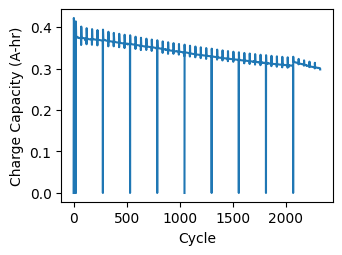

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(dataset.cycle_stats['capacity_charge'])

ax.set_xlabel('Cycle')
ax.set_ylabel('Charge Capacity (A-hr)')

In [6]:
dataset.cycle_stats.head(5)

,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge
0,0,4.336156e-07,1.250638e-07,0.000000,0.000000
1,1,1.460777e+00,3.913738e-01,1.545622,0.420994
2,2,1.562767e+00,4.219583e-01,1.539038,0.419249
3,3,1.555165e+00,4.194255e-01,1.517107,0.413389
4,4,1.534272e+00,4.134042e-01,1.513609,0.412468


## Run for each cell
Load in, create cycle summaries, save back

In [7]:
feature_computers = [CapacityPerCycle(), StateOfCharge(), CycleTimesSummarizer()]

Make a function we can run in parallel

In [8]:
def add_features(file: Path, computers: list):
    """Add features to a certain file"""
    from warnings import catch_warnings, filterwarnings
    dataset = BatteryDataset.from_hdf(str(file))
    with catch_warnings():
        filterwarnings('ignore')
        for feature in feature_computers:
            feature.compute_features(dataset)
    dataset.to_hdf(str(file), complevel=9)
    return file
func = partial(add_features, computers=feature_computers)

In [9]:
for path in tqdm(Path(hdf5_path).rglob('*.h5')):
    func(path)

602it [54:36,  5.44s/it]


## Show the improved HDF5 file
The features are now part of HDF5 file

In [10]:
dataset = BatteryDataset.from_hdf('./data/hdf5/refined/batch_B28B_cell_2.h5')

In [11]:
dataset.cycle_stats.head(5)

,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge,cycle_start,cycle_duration
0,0,4.336156e-07,1.250638e-07,0.000000,0.000000,0.00000,60.048000
1,1,1.460777e+00,3.913738e-01,1.545622,0.420994,60.04800,156219.453125
2,2,1.562767e+00,4.219583e-01,1.539038,0.419249,156279.50000,161755.468750
3,3,1.555165e+00,4.194255e-01,1.517107,0.413389,318034.96875,80239.937500
4,4,1.534272e+00,4.134042e-01,1.513609,0.412468,398274.90625,79615.718750
